<a href="https://colab.research.google.com/github/detauportuno/Projeto_Pinturas_PAE/blob/main/Aula5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

## Aula 5 - Inferência e validação

Agora que você possui uma rede treinada, pode usá-la para fazer previsões. Isso geralmente é chamado de **inferência**, um termo emprestado da estatística. No entanto, as redes neurais tendem a ter um desempenho *muito bom* nos dados de treinamento e não são capazes de generalizar para dados que não foram vistos antes. Isso é chamado de _overfitting_ e prejudica o desempenho da inferência. Para testar o ajuste excessivo durante o treinamento, medimos o desempenho em dados que não estão no conjunto de treinamento chamado **conjunto de validação**. Evitamos o ajuste excessivo através da regularização, como o _Dropout_, enquanto monitoramos o desempenho da validação durante o treinamento.

Como sempre, vamos começar carregando o conjunto de dados através do _torchvision_. Você aprenderá mais sobre a _torchvision_ e o carregamento de dados em uma parte posterior. Desta vez, aproveitaremos o conjunto de testes que você pode obter configurando `train = False` aqui:

```python
testset = datasets.FashionMNIST ('~ / .pytorch / F_MNIST_data /', download = True, train = False, transform = transform)
```

O conjunto de teste contém imagens exatamente como o conjunto de treinamento. Normalmente, você verá de 10 a 20% do conjunto de dados original mantido para teste e validação, sendo o restante usado para treinamento.

In [ ]:
import torch
import numpy as np
from torch import nn, optim
import time
from torchvision import datasets, transforms

# Defina uma transformação para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Faça o download e carregue os dados de treinamento
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Faça o download e carregue os dados de teste
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
# Crie um modelo
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

O objetivo da validação é medir o desempenho do modelo em dados que não fazem parte do conjunto de treinamento. O desempenho aqui depende do desenvolvedor definir. Normalmente, isso é apenas precisão, a porcentagem de classes que a rede previu corretamente. Outras opções são [precisão e revocação](https://pt.wikipedia.org/wiki/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o) e a taxa de erros entre as 5 principais. Vamos nos concentrar na precisão aqui. Primeiro, eu passo adiante com um lote do conjunto de teste.

In [ ]:
# Pega a informação
images, labels = next(iter(testloader))

# "Achata" a imagem
images = images.view(images.shape[0], -1)

# Passe para frente, obtenha nossos logits
ps = torch.exp(model(images))

# Verificar se existem 10 possibilidade para as 64 imagens
print(ps.shape)

torch.Size([64, 10])


Com as probabilidades, podemos obter a classe mais provável usando o método `ps.topk`. Isso retorna os valores mais altos de $ k $. Como queremos apenas a classe mais provável, podemos usar o `ps.topk(1)`. Isso retorna uma tupla dos principais valores de $ k $ e dos principais índices de $ k $. Se o valor mais alto for o quinto elemento, retornaremos 4 como o índice.

In [ ]:
top_p, top_class = ps.topk(1, dim=1)
# Veja as classes mais prováveis para os 10 primeiros exemplos
print(top_class[:10,:])

tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])


Agora podemos verificar se as classes previstas correspondem aos rótulos. Isso é simples, equacionando `top_class` e `labels`, mas temos que ter cuidado com as formas. Aqui `top_class` é um tensor 2D com forma `(64, 1)` enquanto `labels` é 1D com forma `(64)`. Para que a igualdade funcione da maneira que queremos, `top_class` e` labels` devem ter a mesma forma.

Se nós fizermos

`` python
equals = top_class == labels
`` ``

`equals` terá forma `(64, 64) `, tente você mesmo. O que ele está fazendo é comparar o elemento em cada linha de `top_class` com cada elemento em` labels`, que retorna 64 valores booleanos True/False para cada linha.

In [ ]:
equals = top_class == labels.view(*top_class.shape)
print(equals)

tensor([[False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

Agora precisamos calcular a porcentagem de previsões corretas. 'equals' tem valores binários, 0 ou 1. Isso significa que, se somarmos todos os valores e dividirmos pelo número de valores, obteremos a porcentagem de previsões corretas. Esta é a mesma operação que a média, para que possamos obter a precisão com uma chamada para `torch.mean`. Se fosse assim tão simples. Se você tentar `torch.mean(equals)`, você receberá um erro

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

Isso acontece porque `equals` tem o tipo `torch.ByteTensor`, mas o `torch.mean` não é implementado para tensores com esse tipo. Então, precisamos converter "equals" em um tensor de float. Note que quando pegamos o `torch.mean`, ele retorna um tensor escalar, para obter o valor real como um float, precisamos fazer o `accuracy.item()`.

In [ ]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Precisão: {accuracy.item()*100}%')

Precisão: 6.25%


A rede não é treinada, por isso está fazendo suposições aleatórias e devemos ver uma precisão em torno de 10%. Agora vamos treinar nossa rede e incluir nosso passe de validação para que possamos medir o desempenho da rede no conjunto de testes. Como não estamos atualizando nossos parâmetros no passo de validação, podemos acelerar nosso código desativando gradientes usando `torch.no_grad()`:

``` python
# desativar gradientes
with torch.no_grad():
     # passe de validação aqui
     for images, labels in testloader:
        ...
```

> **Exemplo:**

In [ ]:
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 10

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss=0
        accuracy=0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Época: {}/{}.. ".format(e+1, epochs),
              "Perda de treino: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Perda de teste: {:.3f}.. ".format(test_loss/len(testloader)),
              "Precisão de teste: {:.3f}".format(accuracy/len(testloader)))

Época: 1/10..  Perda de treino: 2.115..  Perda de teste: 1.675..  Precisão de teste: 0.467
Época: 2/10..  Perda de treino: 1.186..  Perda de teste: 0.913..  Precisão de teste: 0.686
Época: 3/10..  Perda de treino: 0.795..  Perda de teste: 0.735..  Precisão de teste: 0.739
Época: 4/10..  Perda de treino: 0.680..  Perda de teste: 0.664..  Precisão de teste: 0.756
Época: 5/10..  Perda de treino: 0.622..  Perda de teste: 0.618..  Precisão de teste: 0.772
Época: 6/10..  Perda de treino: 0.582..  Perda de teste: 0.586..  Precisão de teste: 0.789
Época: 7/10..  Perda de treino: 0.551..  Perda de teste: 0.564..  Precisão de teste: 0.796
Época: 8/10..  Perda de treino: 0.526..  Perda de teste: 0.540..  Precisão de teste: 0.804
Época: 9/10..  Perda de treino: 0.505..  Perda de teste: 0.526..  Precisão de teste: 0.810
Época: 10/10..  Perda de treino: 0.488..  Perda de teste: 0.529..  Precisão de teste: 0.808


## Overfitting

Se observarmos as perdas de treinamento e validação à medida que treinamos a rede, podemos ver um fenômeno conhecido como overfitting (sobreajuste).

<div align=center>
<img src="http://numpy.d2l.ai/_images/capacity_vs_error.svg">
</div>

A rede aprende o conjunto de treinamento cada vez melhor, resultando em menores perdas de treinamento. No entanto, ele começa a ter problemas para generalizar dados fora do conjunto de treinamento, levando ao aumento da perda de validação. O objetivo final de qualquer modelo de aprendizado profundo é fazer previsões sobre novos dados; portanto, devemos nos esforçar para obter a menor perda de validação possível. Uma opção é usar a versão do modelo com a menor perda de validação, aqui a de 8 a 10 épocas de treinamento. Essa estratégia é chamada *parada antecipada*. Na prática, você salvaria o modelo frequentemente enquanto treinava e depois escolheria o modelo com a menor perda de validação.

O método mais comum para reduzir o excesso de ajustes (fora da parada antecipada) é o *dropout*, onde eliminamos aleatoriamente as unidades de entrada. Isso força a rede a compartilhar informações entre pesos, aumentando sua capacidade de generalizar para novos dados. Adicionar dropout no PyTorch é simples usando o módulo [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).

```python
model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
```

Durante o treinamento, queremos usar o _dropout_ para evitar o ajuste excessivo, mas durante a inferência, queremos usar toda a rede. Portanto, precisamos desativar o _dropout_ durante a validação, teste e sempre que estivermos usando a rede para fazer previsões. Para fazer isso, você usa `model.eval()`. Isso define o modelo no modo de avaliação, onde a probabilidade de desistência é 0. Você pode reativar a desistência configurando o modelo no modo de treinamento com `model.train()`. Em geral, o padrão para o loop de validação será parecido com este, onde você desativa gradientes, configura o modelo para o modo de avaliação, calcula a perda e métrica de validação e, em seguida, configura o modelo novamente para o modo de treinamento.

```python
# desligue os gradientes
with torch.no_grad():
    
    # ative o modo de avaliação do modelo
    model.eval()
    
    # passe de validação aqui
    for images, labels in testloader:
        ...

# ative novamente o modo de treino
model.train()
```

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA não disponível.  Treinando na CPU ...')
else:
    print('CUDA disponível!  Treinando na GPU ...')

CUDA disponível!  Treinando na GPU ...


In [ ]:
# TODO: Crie seu modelo com Dropout de probabilidade de 25%
model =  nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 2
test_loss_min = np.Inf
begin = time.time()

if train_on_gpu:
    model.to(device)

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                if train_on_gpu:
                    images = images.to(device)
                    labels = labels.to(device)
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
    if test_loss <= test_loss_min:
        print('Perda de teste caiu !({:.6f} --> {:.6f}).  Salvando modelo...'.format(
        test_loss_min,
        test_loss))
        torch.save(model.state_dict(), 'model.pt')
        test_loss_min = test_loss
    print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Perda de treino: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Perda de teste: {:.3f}.. ".format(test_loss/len(testloader)),
              "Precisão de teste: {:.3f}".format(accuracy/len(testloader)))
print(time.time()-begin)

Perda de teste caiu !(inf --> 72.285126).  Salvando modelo...
Epoch: 1/2..  Perda de treino: 0.604..  Perda de teste: 0.460..  Precisão de teste: 0.835
Perda de teste caiu !(72.285126 --> 72.083183).  Salvando modelo...
Epoch: 2/2..  Perda de treino: 0.485..  Perda de teste: 0.459..  Precisão de teste: 0.833
29.543078899383545


## Inferência

Agora que o modelo foi treinado, podemos usá-lo para inferência. Já fizemos isso antes, mas agora precisamos lembrar de definir o modelo no modo de inferência com `model.eval()`. Você também deseja desativar o autograd no contexto `torch.no_grad()`.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Função auxiliar para plotar a imagem
def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['Camiseta',
                             'Calças',
                             'Pullover',
                             'Vestido',
                             'Casaco',
                             'Sandália',
                             'Camisa',
                             'Tênis',
                             'Bolsa',
                             'Bota no tornozelo'], size='small');
    ax2.set_title('Probabilidade de classe')
    ax2.set_xlim(0, 1.1)

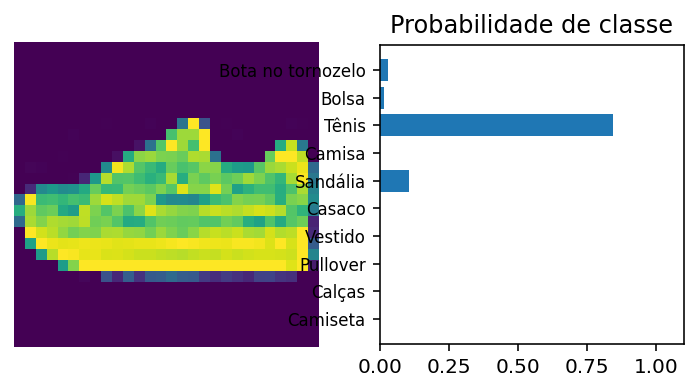

In [ ]:
# Teste sua rede!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Converte imagem 2D para um tensor 1D
img = img.view(1, 784)
model.to(torch.device("cpu"))

# Calcule a probabilidade das classes
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plota imagem e probabilidades

view_classify(img.resize_(1, 28, 28), ps, version='Fashion')